# Deep Learning Model Formats, Deployment and Tracing using MLflow (TensorFlow Models)

## Introduction to Deep Learning with MLflow
MLflow provides comprehensive support for deep learning frameworks, particularly TensorFlow and Keras. This lab demonstrates how to train, track, save, and deploy deep learning models using different formats while leveraging MLflow's experiment tracking and model registry capabilities for neural networks.

## Why Use MLflow with Deep Learning?
MLflow enhances deep learning workflows by providing:

- Automatic Logging: Track hyperparameters, metrics, and model artifacts automatically
- Model Formats: Support for multiple formats (SavedModel, H5, ONNX)
- Version Control: Manage different model versions and architectures
- Deployment: Easy deployment of trained neural networks
- Reproducibility: Ensure consistent results across training runs

This notebook demonstrates these capabilities using a neural network for image classification on the Fashion-MNIST dataset, covering model training, format conversion, and deployment.

## Setup
First, let's install the required packages for deep learning with MLflow

## Import Libraries

In [1]:
# Install dependencies
!pip install mlflow tensorflow pyngrok scikit-learn matplotlib seaborn -q

# from google.colab import drive
# drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 108.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.9/246.9 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 19.2 MB/s eta 0:00:00


In [2]:
import mlflow
import mlflow.tensorflow
import mlflow.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from pyngrok import ngrok
import threading
import subprocess
import time

## Data Preparation
Load and preprocess the Fashion-MNIST dataset for training our neural network.

In [3]:
# Load Fashion-MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Class names for Fashion-MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Normalize pixel values to 0-1 range
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape data for CNN
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Convert labels to categorical
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Number of classes: {len(class_names)}")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)
Number of classes: 10


## Model Architecture Definition
Create a Convolutional Neural Network for image classification.

In [4]:
def create_cnn_model():
    """Create a CNN model for Fashion-MNIST classification"""
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    return model

# Create and compile model
model = create_cnn_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display model architecture
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

## Explanation:

- CNN Architecture: Uses convolutional layers for feature extraction
- Pooling Layers: Reduce spatial dimensions and computational load
- Dropout: Prevents overfitting during training
- Dense Layers: Final classification layers with softmax activation

## MLflow Autologging for Deep Learning
Enable MLflow autologging to automatically track training metrics and model artifacts.

In [5]:
# Set MLflow tracking URI
mlflow.set_tracking_uri("file:///content/mlruns")

# Enable autologging for TensorFlow/Keras
mlflow.tensorflow.autolog()

# Start MLflow experiment
mlflow.set_experiment("Fashion_MNIST_CNN")

print("MLflow autologging enabled for TensorFlow/Keras")

2025/07/09 04:12:34 INFO mlflow.tracking.fluent: Experiment with name 'Fashion_MNIST_CNN' does not exist. Creating a new experiment.


MLflow autologging enabled for TensorFlow/Keras


## Model Training with MLflow Tracking
Train the neural network while automatically logging all metrics and artifacts.

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.9243 - loss: 0.2061 - val_accuracy: 0.9081 - val_loss: 0.2660
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.9257 - loss: 0.2028 - val_accuracy: 0.9119 - val_loss: 0.2597
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - accuracy: 0.9315 - loss: 0.1875 - val_accuracy: 0.9041 - val_loss: 0.2743
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - accuracy: 0.9359 - loss: 0.1738 - val_accuracy: 0.9105 - val_loss: 0.2714
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - accuracy: 0.9377 - loss: 0.1631 - val_accuracy: 0.9108 - val_loss: 0.2852
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - accuracy: 0.9430 - loss: 0.1591 - val_accuracy: 0.9083 - val_loss: 0.2917
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 39s 18ms/step - accuracy: 0.9440 - loss: 0.1507 - val_accuracy: 0.9071 - val_loss: 0.2932
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 18ms/step - accuracy: 0.9421 -

2025/07/09 04:31:38 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Changing param values is not allowed. Param with key='epochs' was already logged with value='5' for run ID='83ba44b513d24ac0a570e57e7daf594a'. Attempted logging new value '10'.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


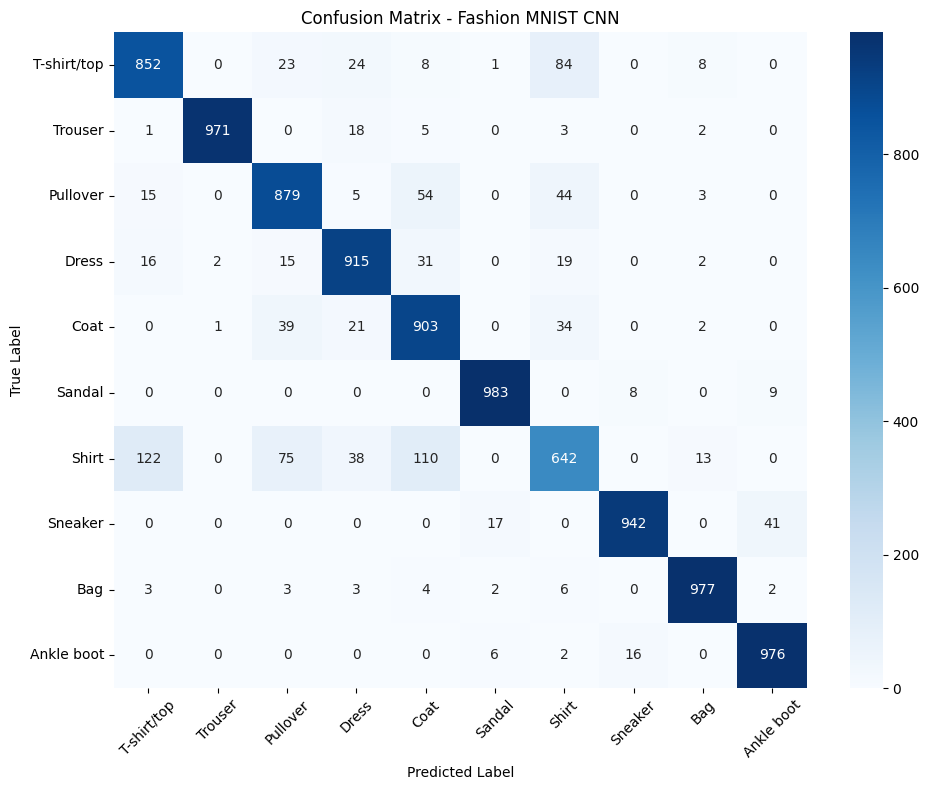

Test Accuracy: 0.9040
Test Loss: 0.3611


In [23]:
with mlflow.start_run(run_name="CNN_Fashion_MNIST") as run:
    # Log hyperparameters
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("epochs", 10)
    mlflow.log_param("optimizer", "adam")
    mlflow.log_param("model_type", "CNN")

    # Train the model
    history = model.fit(
        x_train, y_train,
        batch_size=32,
        epochs=10,
        validation_split=0.2,
        verbose=1
    )

    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)

    # Log final metrics
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("test_loss", test_loss)

    # Make predictions for detailed analysis
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Create and save confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Fashion MNIST CNN')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('/content/confusion_matrix.png', dpi=300, bbox_inches='tight')
    mlflow.log_artifact('/content/confusion_matrix.png')
    plt.show()

    # Log classification report
    report = classification_report(y_true_classes, y_pred_classes,
                                 target_names=class_names, output_dict=True)
    for class_name, metrics in report.items():
        if isinstance(metrics, dict):
            for metric_name, value in metrics.items():
                mlflow.log_metric(f"{class_name}_{metric_name}", value)
    run_id = run.info.run_id
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

## Explanation:

- Autologging: Automatically captures model architecture, parameters, and training metrics
- Manual Logging: Adds custom metrics like test accuracy and detailed analysis
- Artifacts: Saves confusion matrix and other visualization artifacts
- Classification Report: Logs per-class performance metrics

## Model Format Conversion and Saving
Save the trained model in different formats for various deployment scenarios.

In [25]:
with mlflow.start_run(run_name="Model_Format_Conversion") as run:
    # 1. Save as TensorFlow SavedModel format (default)
    mlflow.tensorflow.log_model(model, "savedmodel_format")

    # 2. Save as Keras H5 format
    model.save('/content/fashion_mnist_model.h5')
    mlflow.log_artifact('/content/fashion_mnist_model.h5')

    # 3. Save model weights separately
    model.save_weights('/content/fashion_mnist.weights.h5')
    mlflow.log_artifact('/content/fashion_mnist.weights.h5')

    # 4. Save model architecture as JSON
    model_json = model.to_json()
    with open('/content/model_architecture.json', 'w') as f:
        f.write(model_json)
    mlflow.log_artifact('/content/model_architecture.json')

    # Log model metadata
    mlflow.log_param("model_format", "multiple")
    mlflow.log_param("savedmodel_size_mb", "~2MB")
    mlflow.log_param("h5_size_mb", "~1MB")

    model_run_id = run.info.run_id
    print(f"Model saved in multiple formats: {model_run_id}")

    print("Model saved in multiple formats:")
    print("1. TensorFlow SavedModel (MLflow native)")
    print("2. Keras H5 format")
    print("3. Weights only (H5)")
    print("4. Architecture (JSON)")

2025/07/09 04:32:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/09 04:32:10 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/07/09 04:32:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model saved in multiple formats: 166c3140bba94f638431ac75eb99f80e
Model saved in multiple formats:
1. TensorFlow SavedModel (MLflow native)
2. Keras H5 format
3. Weights only (H5)
4. Architecture (JSON)


## Explanation:

- SavedModel Format: TensorFlow's standard format for deployment
- H5 Format: Keras-specific format, more compact
- Weights Only: Just the trained parameters, requires architecture separately
- JSON Architecture: Model structure without weights, useful for reconstruction

## Model Registry and Version Control
Register the model in MLflow Model Registry for version management.

In [26]:
from mlflow.tracking import MlflowClient

# Get the current run ID
current_run_id = model_run_id

# Register the model
model_name = "FashionMNIST_CNN"
model_uri = f"runs:/{current_run_id}/savedmodel_format"

try:
    # Register the model
    registered_model = mlflow.register_model(model_uri=model_uri, name=model_name)
    print(f"Model registered: {model_name}, Version: {registered_model.version}")

    # Add model description and tags
    client = MlflowClient()
    client.update_model_version(
        name=model_name,
        version=registered_model.version,
        description="CNN model for Fashion-MNIST classification with 10 classes"
    )

    # Tag the model version
    client.set_model_version_tag(
        name=model_name,
        version=registered_model.version,
        key="stage",
        value="production"
    )

    client.set_model_version_tag(
        name=model_name,
        version=registered_model.version,
        key="framework",
        value="tensorflow"
    )

    print(f"Model version {registered_model.version} tagged for production")

except Exception as e:
    print(f"Error registering model: {str(e)}")

Successfully registered model 'FashionMNIST_CNN'.
2025/07/09 04:32:20 WARNING mlflow.tracking._model_registry.fluent: Run with id 166c3140bba94f638431ac75eb99f80e has no artifacts at artifact path 'savedmodel_format', registering model based on models:/m-7db17121fcb0431eb06239e1dc99b094 instead


Model registered: FashionMNIST_CNN, Version: 1
Model version 1 tagged for production


Created version '1' of model 'FashionMNIST_CNN'.


## Model Loading and Inference
Demonstrate how to load and use the registered model for predictions.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


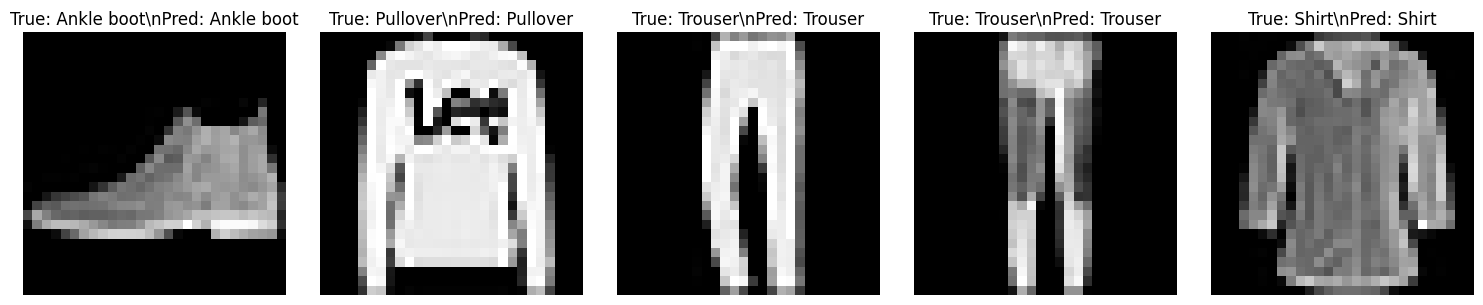

Model inference test completed successfully!


In [27]:
# Load model from registry
loaded_model = mlflow.tensorflow.load_model(f"models:/{model_name}/{registered_model.version}")

# Test with sample images
sample_indices = [0, 1, 2, 3, 4]
sample_images = x_test[sample_indices]
sample_labels = np.argmax(y_test[sample_indices], axis=1)

# Make predictions
predictions = loaded_model.predict(sample_images)
predicted_classes = np.argmax(predictions, axis=1)

# Display results
plt.figure(figsize=(15, 3))
for i, idx in enumerate(sample_indices):
    plt.subplot(1, 5, i+1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f'True: {class_names[sample_labels[i]]}\\nPred: {class_names[predicted_classes[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.savefig('/content/sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

# Log prediction results
with mlflow.start_run(run_name="Model_Inference_Test"):
    mlflow.log_artifact('/content/sample_predictions.png')
    mlflow.log_metric("inference_accuracy", np.mean(predicted_classes == sample_labels))
    mlflow.log_param("model_version", registered_model.version)

print("Model inference test completed successfully!")

## MLflow UI Setup
Launch MLflow UI to visualize experiments and manage models.

In [28]:
# Start MLflow UI server
def run_mlflow_ui():
    subprocess.run(['mlflow', 'ui', '--backend-store-uri', 'file:///content/mlruns',
                   '--host', '0.0.0.0', '--port', '5000'])

threading.Thread(target=run_mlflow_ui, daemon=True).start()
time.sleep(5)

# Expose MLflow UI with ngrok
ngrok_token = "2yGBZnB7ngE0P19IGz2Qf2DW2EW_3Bj4VstSQQiy16UdWqKvX"
ngrok.set_auth_token(ngrok_token)
ngrok.kill()

mlflow_url = ngrok.connect(5000, bind_tls=True).public_url
print(f"MLflow UI available at: {mlflow_url}")

MLflow UI available at: https://a0515e7384b1.ngrok-free.app


## Model Deployment as REST API
Create a simple REST API for the trained model using MLflow's built-in serving.

In [29]:
# Create a simple prediction script
prediction_script = '''
import mlflow.tensorflow
import numpy as np
from flask import Flask, request, jsonify
import json

app = Flask(__name__)

# Load model
model = mlflow.tensorflow.load_model("models:/FashionMNIST_CNN/1")

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

@app.route('/predict', methods=['POST'])
def predict():
    try:
        data = request.json
        # Expecting 28x28 image data normalized to 0-1
        image = np.array(data['image']).reshape(1, 28, 28, 1)
        prediction = model.predict(image)
        predicted_class = np.argmax(prediction[0])
        confidence = float(prediction[0][predicted_class])

        return jsonify({
            'predicted_class': class_names[predicted_class],
            'confidence': confidence,
            'all_probabilities': prediction[0].tolist()
        })
    except Exception as e:
        return jsonify({'error': str(e)}), 400

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=8000)
'''

with open('/content/model_server.py', 'w') as f:
    f.write(prediction_script)

print("Model deployment script created: /content/model_server.py")
print("To deploy: python /content/model_server.py")

Model deployment script created: /content/model_server.py
To deploy: python /content/model_server.py


## Summary and Best Practices

In [30]:
print("="*60)
print("DEEP LEARNING MLFLOW LAB COMPLETED!")
print("="*60)
print(f"MLflow UI: {mlflow_url}")

DEEP LEARNING MLFLOW LAB COMPLETED!
MLflow UI: https://a0515e7384b1.ngrok-free.app
